## Plot results for influenza tree

Mamie Wang 2020/10/14



Test run time and accuracy against the length of sequences for caterpillar tree of size 1611. 

Scripts: `sbatch --array = `
List of experiments: `../test_catepillar_tree.lst`

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns
from matplotlib import cm

In [9]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import generation
import reconstruct_tree
import time
import utils
import pandas as pd
import argparse
import dendropy

In [20]:
# Find suitable parameters for caterpillar trees
tree_path = os.path.join(os.path.dirname(sys.path[0]), "../data/nextstrain_flu_seasonal_h1n1pdm_ha_2y_tree.nwk")
tree = dendropy.Tree.get(path=tree_path, schema="newick")

m = 3000
mutation_rate = 0.5
kappa = 2
observations, taxa_meta = generation.simulate_sequences(m, tree_model=tree, seq_model=generation.HKY(kappa = kappa), 
                                                        mutation_rate=mutation_rate, alphabet="DNA")

threshold = 64
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.HKY_similarity_matrix,
                                                            taxa_metadata = taxa_meta,
                                                            threshhold = threshold, min_split = 5, verbose = False)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)


m   |  mutation rate |  F1 %    |  RF     
----|--------------|----------|------
800 | 0.01         | 53       | 2766
800 | 0.1          | 54       | 2702
800 | 0.3          | 56       | 2622
1500| 0.3          | 57       | 2532
1500| 0.5          | 57       | 2516
3000 | 0.5         | 60       | 2356 

In [26]:
# Find suitable parameters for birth and death trees
tree = utils.unrooted_birth_death_tree(2000)

m = 400
mutation_rate = 0.05
kappa = 2
observations, taxa_meta = generation.simulate_sequences(m, tree_model=tree, seq_model=generation.HKY(kappa = kappa), 
                                                        mutation_rate=mutation_rate, alphabet="DNA")

threshold = 64
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.HKY_similarity_matrix,
                                                            taxa_metadata = taxa_meta,
                                                            threshhold = threshold, min_split = 5, verbose = False)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)


64
--- 320.4419093132019 seconds ---
RF =  832
F1% =  89.59479739869936


m   |  mutation rate |  F1 %    |  RF     
----|--------------|----------|------
400 | 0.05         | 89       | 832
800 | 0.01         |   83     | 1290
800 | 0.05         |   94     | 454
800 | 0.1          |   92     | 588
800 | 0.3          |   65     | 2762

In [27]:
# write out list of parameters to run

m = [400, 600, 800, 1000, 1200]
tree_type = "birthdeath"
method = ["NJ", "SNJ", "RAxML", 
          "STDR+NJ", "STDR+NJ", "STDR+NJ", 
          "STDR+SNJ", "STDR+SNJ", "STDR+SNJ", 
          "STDR+RAxML", "STDR+RAxML", "STDR+RAxML"]
nrun = 5
size = 2000
path = "None"
threshold = [0] * 15 + list(np.repeat([256, 128, 64] * 3, 5))
kappa = 2
mutation_rate = 0.05
verbose = True
m_lst = np.tile(m, 12)

In [28]:
par_list = pd.DataFrame({"type": tree_type, "method": np.repeat(method, 5), 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m_lst, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [30]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_birthdeath_tree.lst", 
                sep = "\t",  index = False)

In [2]:
import glob
import pandas as pd
import re
from matplotlib import cm

def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/birthdeath_m*")
metrics, summarized = summarize_perf(paths)
summarized

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


runtime             RF             F1      
                          mean     std   mean     std   mean   std
m    method                                                       
400  RAxML             2038.34   64.83  292.0   18.87  96.35  0.24
     STDR+RAxML (128)   772.09   20.10  460.8   65.52  94.24  0.82
     STDR+RAxML (256)   744.34   17.83  572.8  105.71  92.84  1.32
     STDR+NJ (128)      318.28    3.37  584.4   32.11  92.69  0.40
     STDR+RAxML (64)    636.49    5.54  593.6   76.53  92.58  0.96
     SNJ               1188.18   61.66  712.8   39.46  91.09  0.49
     STDR+SNJ (256)     322.17    2.35  724.0   30.82  90.95  0.39
     STDR+SNJ (128)     246.53    4.93  740.8   51.24  90.74  0.64
     STDR+NJ (256)      238.16    5.76  744.0   93.34  90.70  1.17
     NJ                1763.40   33.73  763.2   22.52  90.46  0.28
     STDR+NJ (64)       371.84    3.29  858.4   59.96  89.26  0.75
     STDR+SNJ (64)      236.28    3.09  950.4   46.59  88.11  0.58
600  RAxML             2862.57   80.87  221.2   28.52  97.23  0.36
     STDR+RAxML (128)  1173.85   13.24  313.2   10.73  96.08  0.13
     STDR+RAxML (256)   958.94   21.81  321.2   67.03  95.98  0.84
     STDR+RAxML (64)    806.55   14.00  413.2   14.87  94.83  0.19
     STDR+NJ (256)      360.07    3.29  432.8   33.54  94.59  0.42
     STDR+NJ (64)       348.88    5.19  498.4   43.55  93.77  0.54
     STDR+NJ (128)      235.56    1.93  561.2   63.02  92.98  0.79
     STDR+SNJ (128)     341.32    1.36  582.4   32.54  92.72  0.41
     STDR+SNJ (256)     384.37    4.09  661.6   23.08  91.73  0.29
     SNJ               1236.54   68.35  666.0   21.12  91.67  0.26
     NJ                1793.28   26.10  703.6   38.87  91.20  0.49
     STDR+SNJ (64)      245.22    2.43  833.2   57.25  89.58  0.72
800  RAxML             3480.14   44.45  214.0   19.24  97.32  0.24
     STDR+RAxML (256)  1582.12   24.44  218.0   33.76  97.27  0.42
     STDR+RAxML (128)  1249.94   11.64  308.4   43.25  96.14  0.54
     STDR+NJ (128)      352.17    3.18  364.8   20.81  95.44  0.26
     STDR+NJ (256)      254.74    1.78  406.8   51.97  94.91  0.65
     STDR+NJ (64)       238.29    3.08  420.0   40.55  94.75  0.51
     STDR+RAxML (64)    924.96   15.04  528.4   81.02  93.39  1.01
     SNJ               1261.80   73.32  568.0   24.94  92.90  0.31
     STDR+SNJ (128)     355.87    1.66  572.8   39.00  92.84  0.49
     STDR+SNJ (64)      259.58    5.59  574.8   55.87  92.81  0.70
     STDR+SNJ (256)     374.74    4.48  604.0   40.05  92.45  0.50
     NJ                1916.30   22.23  720.0   56.80  91.00  0.71
1000 RAxML             5070.16  123.18  153.2   11.97  98.08  0.15
     STDR+RAxML (256)  1949.50   39.60  174.4   15.06  97.82  0.19
     STDR+RAxML (128)  1385.82   33.50  308.0   62.29  96.15  0.78
     STDR+NJ (256)      251.42    5.12  345.6   31.67  95.68  0.40
     STDR+NJ (128)      381.21   12.53  400.4   37.59  94.99  0.47
     STDR+SNJ (256)     387.12    4.72  485.6   32.23  93.93  0.40
     SNJ               1168.77   60.23  513.6   26.36  93.58  0.33
     STDR+SNJ (64)      255.05    1.33  534.4   45.13  93.32  0.56
     NJ                1391.66   67.69  546.8   43.00  93.16  0.54
     STDR+SNJ (128)     257.23    3.10  550.0   57.64  93.12  0.72
     STDR+NJ (64)       374.99    8.01  594.0  105.21  92.57  1.32
     STDR+RAxML (64)   1057.37   19.05  618.8   87.44  92.26  1.09
1200 RAxML             5319.30   82.68  116.4   12.28  98.54  0.15
     STDR+RAxML (256)  2414.23   22.55  142.8   22.57  98.21  0.28
     STDR+RAxML (128)  1636.12   51.90  283.6   98.01  96.45  1.23
     STDR+NJ (256)      265.30    2.87  300.0   19.44  96.25  0.24
     STDR+NJ (128)      393.16    9.22  358.4   42.60  95.52  0.53
     STDR+RAxML (64)   1225.16   28.42  408.8   67.09  94.89  0.84
     NJ                1408.87   32.71  429.6   23.89  94.63  0.30
     STDR+SNJ (256)     296.16    3.82  432.4    9.42  94.59  0.12
     STDR+NJ (64)       400.15    8.60  454.8  100.54  94.31  1.26
   

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


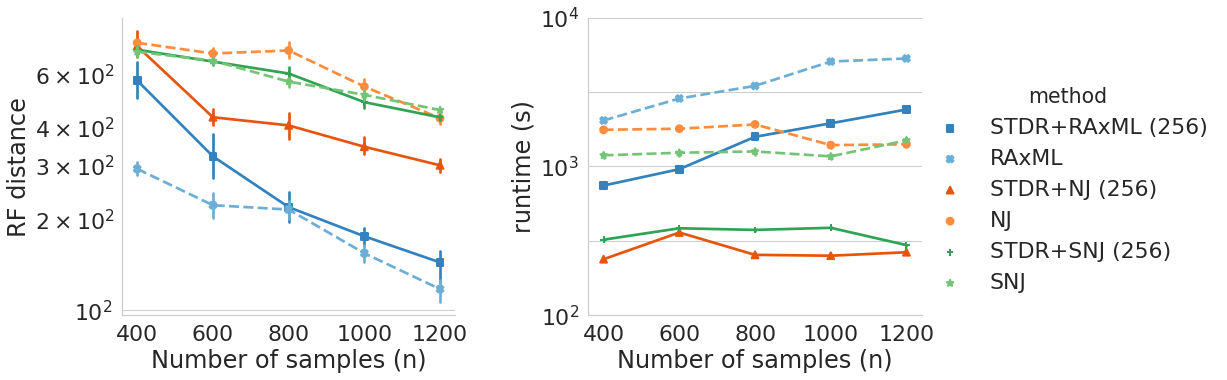

In [3]:
import glob
import pandas as pd
import re
from matplotlib import cm
import matplotlib

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/birthdeath_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (256)", "RAxML", "STDR+NJ (256)","NJ",  "STDR+SNJ (256)", "SNJ"]

selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")


df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] + 1
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

color_dict = dict(zip(ordering, np.array([colors[i] for i in [0,1,4,5,8,9]])))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = ["s", "X", "^", "o", "+", "*"], 
                linestyles=["-", "--", "-", "--", "-", "--"], 
                
                legend_out= True, gridspec_kws={"wspace":0.4})

labels = ["RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    ax.set(yscale="log")
    if i == 1:
        ax.set_yticks([10**2, 300, 600])
    if i == 1:
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**2.5, 10**3, 10**3.5, 10**4])
    
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)
plt.plot()
plt.savefig("birth_death_performance.eps")